In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics



### Import data

In [78]:
originalDataX = pd.read_csv('data/Data_X.csv')
originalDataY = pd.read_csv('data/Data_Y.csv')
originalDataNew = pd.read_csv('data/DataNew_X.csv')

In [79]:
# Merge X and Y

df = pd.merge(originalDataX, originalDataY, on='ID')


### Data Preparation


In [80]:
# Remove unnecessary columns

df = df.drop(['ID'], axis=1)

In [81]:
# Remove duplicated values
df = df.drop_duplicates()
print(df.duplicated().sum())

0


In [82]:
df = df.dropna()

In [83]:
# Label encoding

le = LabelEncoder()
le.fit(['FR', 'DE'])
df['COUNTRY'] = le.transform(df['COUNTRY'])


print(df.head())

   DAY_ID  COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE   
1     501        1       -0.022399       -1.003452       -0.022063  \
2     687        1        1.395035        1.978665        1.021305   
3     720        0       -0.983324       -0.849198       -0.839586   
5     467        1       -0.295296       -0.765120       -0.717490   
6     144        1       -0.234965       -0.677085        0.399588   

   FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  FR_NET_IMPORT   
1        0.022063      -0.573520      -1.130838       0.573520       1.130838  \
2       -1.021305      -0.622021      -1.682587       0.622021       1.682587   
3        0.839586      -0.270870       0.563230       0.270870      -0.563230   
5        0.717490      -1.117139      -0.200305       1.117139       0.200305   
6       -0.399588       0.183998      -0.986235      -0.183998       0.986235   

   ...   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP   FR_TEMP   GAS_RET   
1  ... -1.24

In [84]:
# Scale data
sc = StandardScaler()
df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)




### Data Exploration

In [85]:
# List columns
print(df.columns)

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')


In [86]:
# Describe data
print(df.describe())

             DAY_ID       COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION   
count  1.276000e+03  1.276000e+03    1.276000e+03    1.276000e+03  \
mean  -5.011665e-17  2.784258e-17    2.227407e-17   -8.352775e-18   
std    1.000392e+00  1.000392e+00    1.000392e+00    1.000392e+00   
min   -1.716719e+00 -1.068148e+00   -3.935100e+00   -1.563610e+00   
25%   -8.662014e-01 -1.068148e+00   -6.523718e-01   -7.260343e-01   
50%   -6.915172e-03  9.362001e-01   -1.155892e-01   -4.137645e-01   
75%    8.647927e-01  9.362001e-01    7.563681e-01    6.387449e-01   
max    1.822722e+00  9.362001e-01    2.512826e+00    2.979626e+00   

       DE_FR_EXCHANGE  FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT   
count    1.276000e+03    1.276000e+03    1276.000000   1.276000e+03  \
mean     3.341110e-17   -3.341110e-17       0.000000  -1.670555e-17   
std      1.000392e+00    1.000392e+00       1.000392   1.000392e+00   
min     -2.779043e+00   -2.836752e+00      -2.273731  -2.473398e+00   
25%     -8.426723e-01  

In [87]:
# Variance
print(df.var())

DAY_ID              1.000784
COUNTRY             1.000784
DE_CONSUMPTION      1.000784
FR_CONSUMPTION      1.000784
DE_FR_EXCHANGE      1.000784
FR_DE_EXCHANGE      1.000784
DE_NET_EXPORT       1.000784
FR_NET_EXPORT       1.000784
DE_NET_IMPORT       1.000784
FR_NET_IMPORT       1.000784
DE_GAS              1.000784
FR_GAS              1.000784
DE_COAL             1.000784
FR_COAL             1.000784
DE_HYDRO            1.000784
FR_HYDRO            1.000784
DE_NUCLEAR          1.000784
FR_NUCLEAR          1.000784
DE_SOLAR            1.000784
FR_SOLAR            1.000784
DE_WINDPOW          1.000784
FR_WINDPOW          1.000784
DE_LIGNITE          1.000784
DE_RESIDUAL_LOAD    1.000784
FR_RESIDUAL_LOAD    1.000784
DE_RAIN             1.000784
FR_RAIN             1.000784
DE_WIND             1.000784
FR_WIND             1.000784
DE_TEMP             1.000784
FR_TEMP             1.000784
GAS_RET             1.000784
COAL_RET            1.000784
CARBON_RET          1.000784
TARGET        

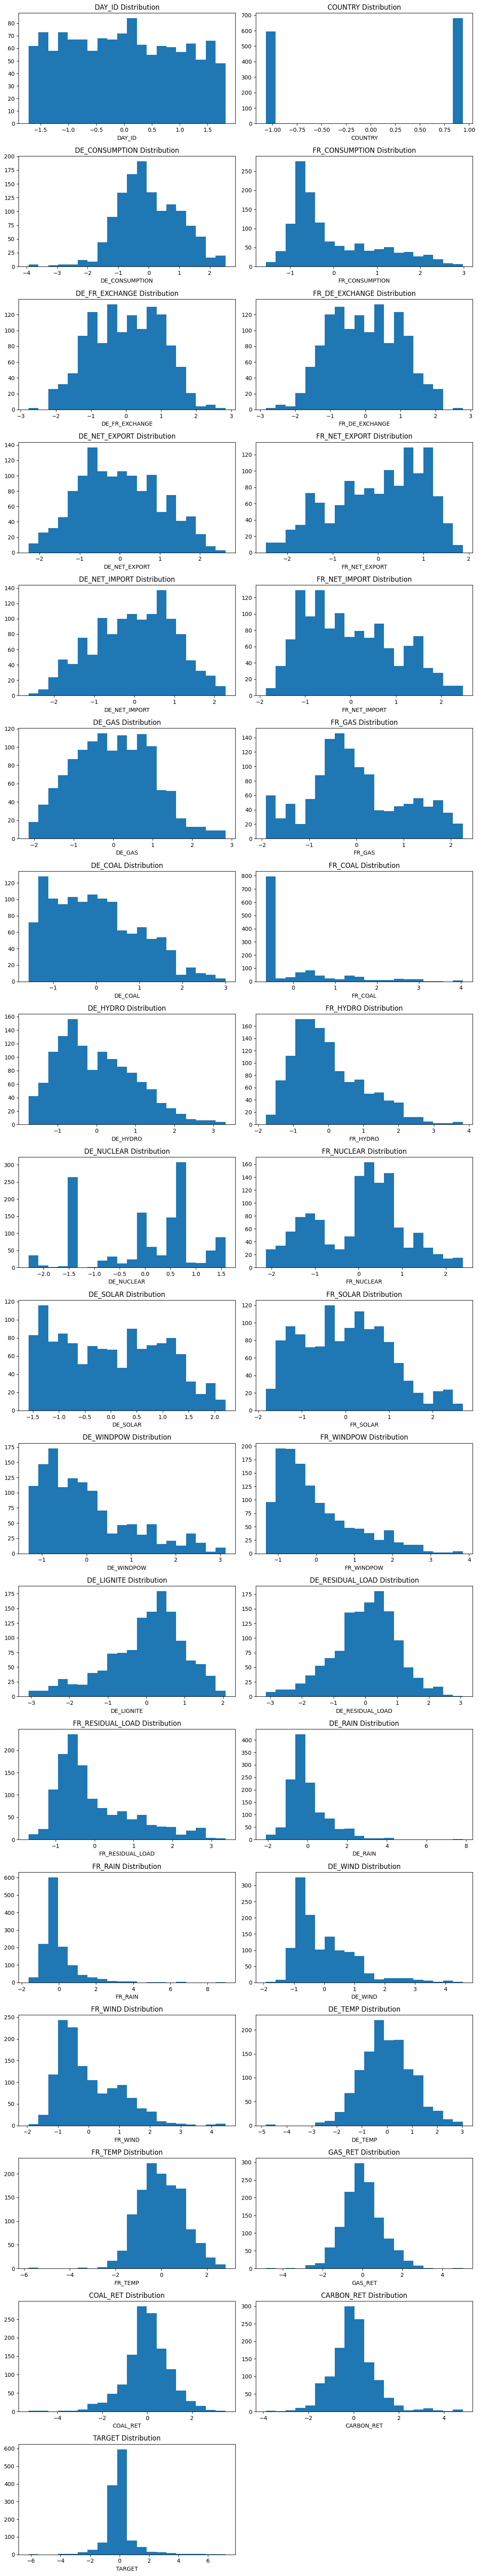

In [88]:
#Plot repartition of the data

plt.figure(figsize=(12,64))

for i, j in enumerate(df.columns):
    plt.subplot(18,2, i+1)
    # Histogram
    plt.hist(df[j], bins=20)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.subplots_adjust(wspace=.2, hspace=.5)
    plt.tight_layout()
plt.show()

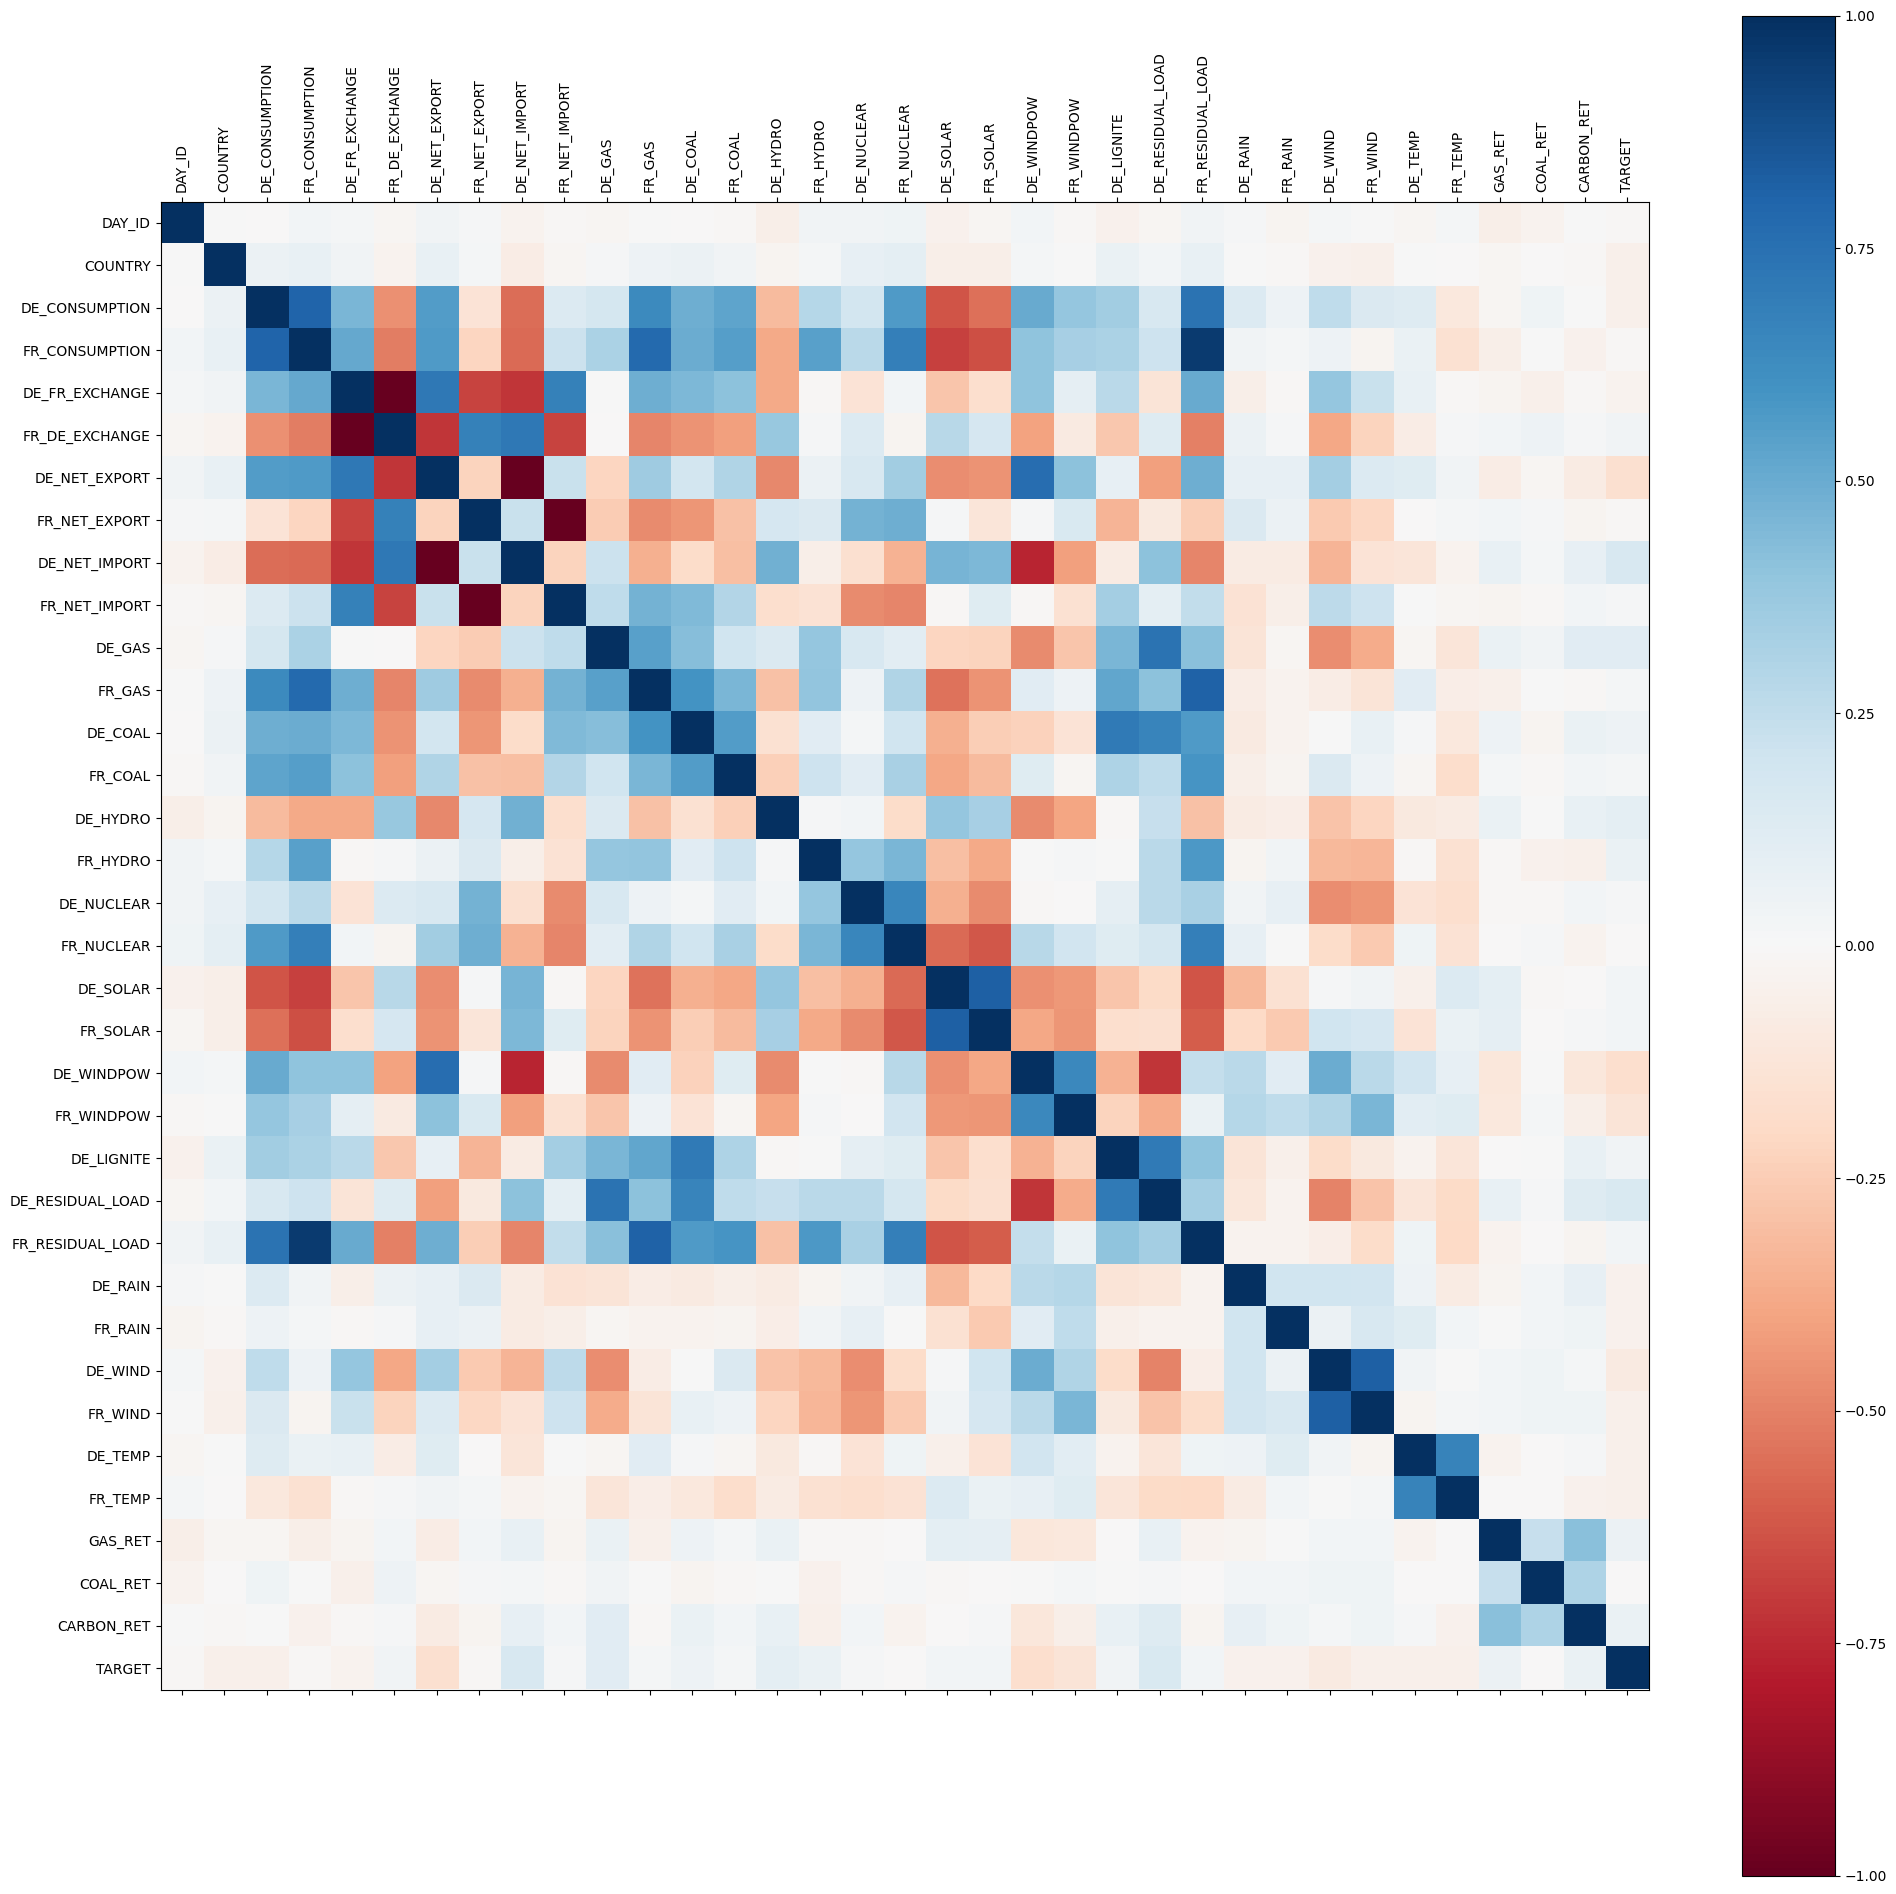

In [89]:
# Plot correlation matrix with heatmap

corr = df.corr()

plt.figure(figsize=(24, 24))
plt.matshow(corr, fignum=1, cmap='RdBu')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [90]:
# Print each column correlation with each other
treashold = 0.75
variable_seen = []
highest_correlation = []
for i in df.columns:
    for j in df.columns:
        if (i, j) not in variable_seen:
            variable_seen += [(j, i)]
            if i != j and df[i].corr(df[j]) > treashold or df[i].corr(df[j]) < -treashold :
                print("{:>20} <---> {:<20} :  {}".format(i, j, df[i].corr(df[j])))
                highest_correlation.append(i)


      DE_CONSUMPTION <---> FR_CONSUMPTION       :  0.8000247966026744
      FR_CONSUMPTION <---> FR_GAS               :  0.7810476807964117
      FR_CONSUMPTION <---> FR_RESIDUAL_LOAD     :  0.9608380589254399
      DE_FR_EXCHANGE <---> FR_DE_EXCHANGE       :  -0.9999999999999998
       DE_NET_EXPORT <---> DE_NET_IMPORT        :  -0.9999999999999998
       DE_NET_EXPORT <---> DE_WINDPOW           :  0.7611406500398217
       FR_NET_EXPORT <---> FR_NET_IMPORT        :  -1.0
       DE_NET_IMPORT <---> DE_WINDPOW           :  -0.7611406500398217
              FR_GAS <---> FR_RESIDUAL_LOAD     :  0.8080327645909665
            DE_SOLAR <---> FR_SOLAR             :  0.8130806182049253
             DE_WIND <---> FR_WIND              :  0.8151382177312319


##### Interpretation of correlations

What we can deduce is that the french and german's consumption is extremely linked, with a correlation of 80%.
We can also see that the french consumption is linked to the gas consumption at 78%, so french electricity depends on gas a lot.
The more the french consumption augments, the more they use the residual load, because there aren't enough renewable energies. We can also see that the residual load is mostly constitued by gas.
Germans export a lot of wind energy.

When french's solar energy is high, the german's solar energy is high too, most likely because the two countries are close and subject to the same weather conditions.

In [91]:
# Delete columns with high correlation

df = df.drop(highest_correlation, axis=1)

### Data Analysis

In [94]:
# linear regression

X = df.copy().drop(['TARGET'], axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


linear_regression = LinearRegression()

reg = linear_regression.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('Coefficients: \n')
# Print coefficient for each variable
for i, j in enumerate(X.columns):
    print("{:<15} : {}".format(j, reg.coef_[i]))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score:', metrics.r2_score(y_test, y_pred))




Coefficients: 

DAY_ID          : -0.028592453544018948
COUNTRY         : -0.048891052551337875
FR_DE_EXCHANGE  : -0.14627749556555084
FR_NET_IMPORT   : 0.057701993577920066
DE_GAS          : -0.11579705366735697
DE_COAL         : -0.21936977983055905
FR_COAL         : 0.012082337188510962
DE_HYDRO        : -0.0029163884302604304
FR_HYDRO        : 0.029663275471573707
DE_NUCLEAR      : -0.08533645799930534
FR_NUCLEAR      : 0.10205812857837698
FR_SOLAR        : -0.08141215544497782
DE_WINDPOW      : 0.029324684025318626
FR_WINDPOW      : -0.11677042707800302
DE_LIGNITE      : -0.1661011646817917
DE_RESIDUAL_LOAD : 0.5536730236472924
FR_RESIDUAL_LOAD : -0.08047251730534012
DE_RAIN         : -0.026825208318602953
FR_RAIN         : -0.059026867082208306
FR_WIND         : 0.07514182751993383
DE_TEMP         : -0.024683096769607865
FR_TEMP         : 0.010732494560089062
GAS_RET         : 0.03466026882382126
COAL_RET        : -0.01404684884504467
CARBON_RET      : 0.025462093129606712
Mean A

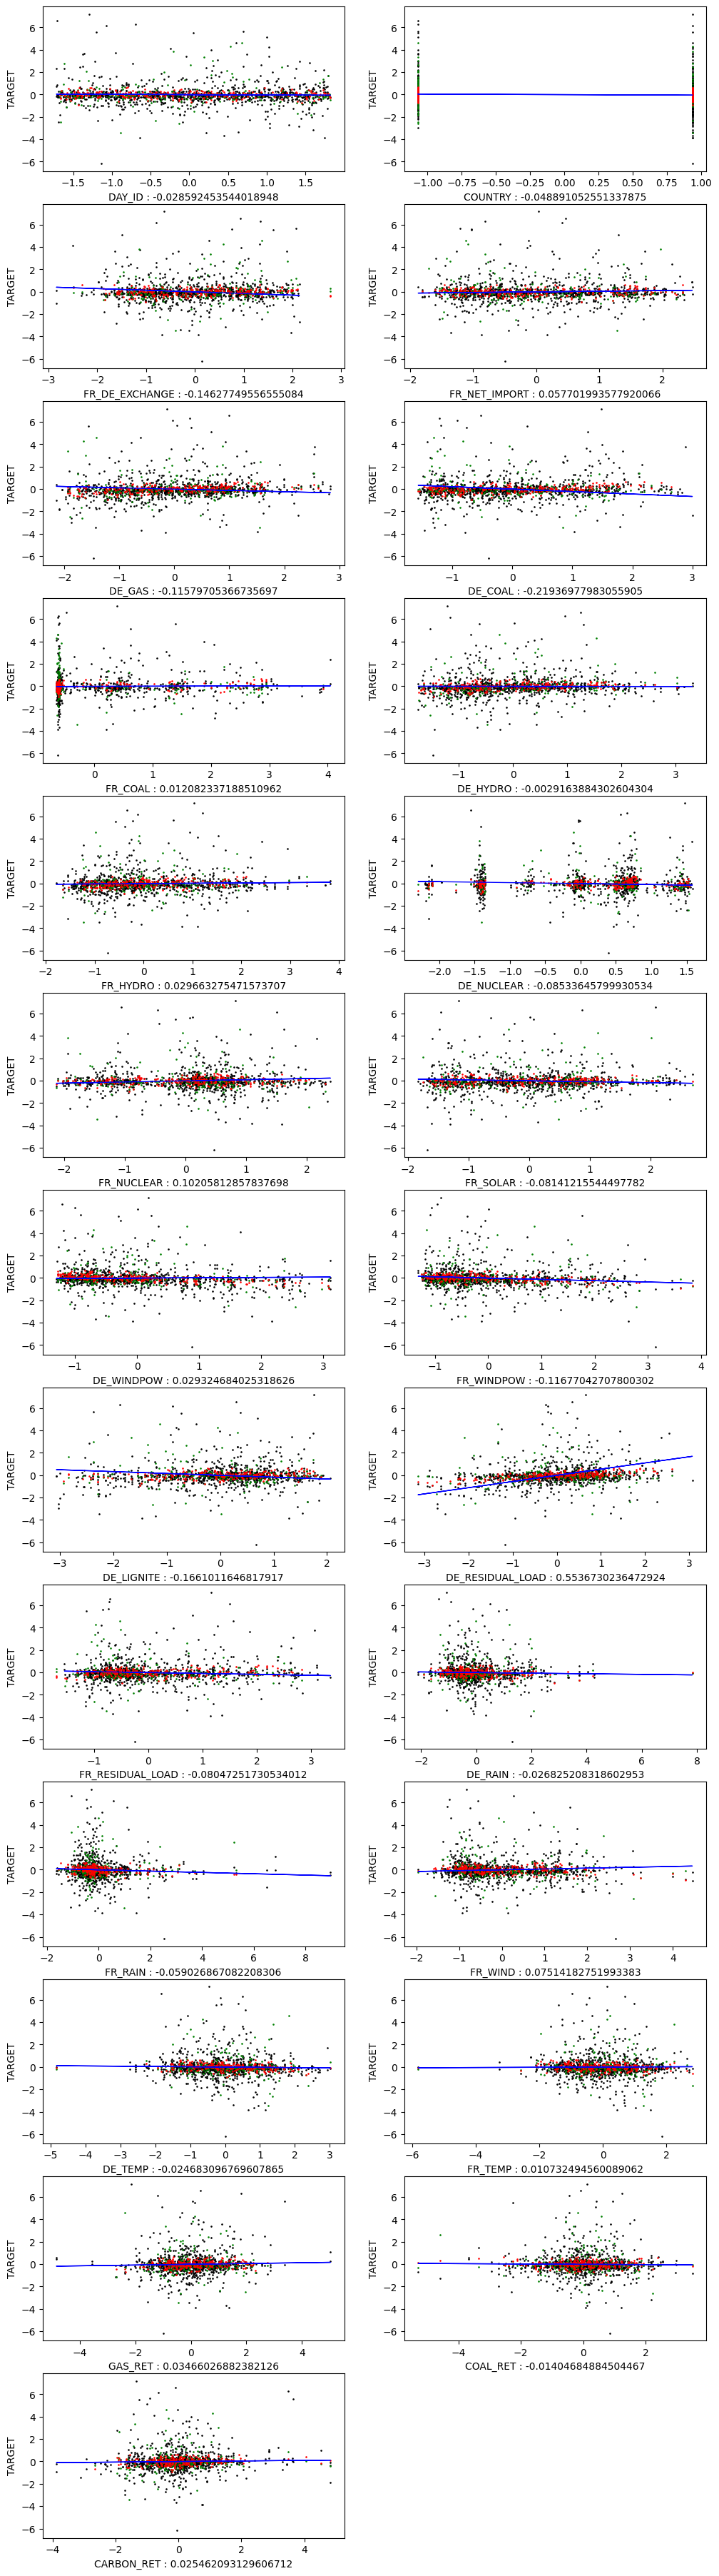

In [107]:
# Plot the linear regression affine function
plt.figure(figsize=(12,64))

for i, j in enumerate(X.columns):

    plt.subplot(18,2, i+1)
    plt.scatter(X_train[j], y_train,  color='black', s=0.8)

    plt.scatter(X_test[j], y_test,  color='green', s=0.8)
    plt.scatter(X_test[j], y_pred,  color='red', s=0.8)

    plt.plot(X_train[j], reg.coef_[i] * X_train[j] + reg.intercept_, color='blue', linewidth=1)

    plt.xlabel(j + " : " + str(reg.coef_[i]))
    plt.ylabel("TARGET")

    # Show the coefficient of the linear regression


    # Plot line from linear regression coefficients

    


    
    

# plt.scatter(X_test['FR_NET_EXPORT'], y_test,  color='black')
# plt.plot(X_test['FR_NET_EXPORT'], y_pred, color='blue', linewidth=1)
# plt.show()